<a href="https://colab.research.google.com/github/amita-kapoor/Designing-Models-for-Responsible-AI/blob/main/Chapter8/Fairness_ParameterPrejudiceRemover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/prejudice_remover_regularizer
!pip install nnabla-ext-cuda100

fatal: destination path 'nnabla-examples' already exists and is not an empty directory.
/content/nnabla-examples/responsible_ai/prejudice_remover_regularizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import nnabla as nn
from nnabla.logger import logger
from nnabla.ext_utils import get_extension_context
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as Sol
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Markdown

from utils import load_adult_dataset, CVS, fairness_plot

In [ ]:
X, y, S = load_adult_dataset()
S = S.drop(['race'], axis = 1)

# split into train/test set
X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(X, y, S, test_size=0.3, stratify=y, random_state=89)

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

features : 28750 samples, 88 attributes

targets : 28750 samples

sensitives attributes : 28750 samples, 2 attributes

In [ ]:
class dataGenerator(DataSource):
    def __init__(self,features, labels, senstive_features, shuffle=False):
        super(dataGenerator, self).__init__(shuffle=shuffle)
        self.x = features
        self.y = labels.reshape(-1, 1)
        self.s = senstive_features
        self._size = self.y.size
        self._variables = ('x', 'y', 's')
        
    def _get_data(self, idx):
        return self.x[idx], self.y[idx], self.s[idx]

train_data = dataGenerator(X_train, y_train.to_numpy(), S_train.to_numpy(), shuffle=True)
test_data = dataGenerator(X_test, y_test.to_numpy(), S_test.to_numpy())

batchsize = 32
test_batchsize = X_test.shape[0]

train_loader = data_iterator(train_data, batch_size=batchsize)
test_loader = data_iterator(test_data, batch_size=test_batchsize)

In [ ]:
ctx = get_extension_context("cudnn", device_id=0) # For one default GPU
nn.set_default_context(ctx)

In [ ]:
n_feat = nn.Variable((batchsize, 88))
n_class = nn.Variable((batchsize, 1))
n_senstive = nn.Variable((batchsize, 1))

test_feat = nn.Variable((test_batchsize, 88))
test_class = nn.Variable((test_batchsize, 1))
test_senstive = nn.Variable((test_batchsize, 1))

In [ ]:
def Classifier(n_features, n_hidden=32, p_dropout=0.2,train=True):
    with nn.parameter_scope('classifier'):
        layer1 = PF.affine(n_features, n_hidden, name='layer1')
        layer1 = F.relu(layer1)
        if (train):
            layer1 = F.dropout(layer1,p_dropout)
        layer2 = PF.affine(layer1, n_hidden, name='layer2')
        layer2 = F.relu(layer2)
        if (train):
            layer2 = F.dropout(layer2,p_dropout)
        layer3 = PF.affine(layer2, n_hidden, name='layer3')
        layer3 = F.relu(layer3)
        if (train):
            layer3 = F.dropout(layer3,p_dropout)
        layer4 = PF.affine(layer3, 1, name='layer4')
    return layer4

In [ ]:
clf = Classifier(n_feat)
clf_sigm = F.sigmoid(clf)
clf.persistent = True
clf_sigm.persistent = True

In [ ]:
t_clf = Classifier(test_feat,train=False)

In [ ]:
loss = F.sum(F.sigmoid_cross_entropy(clf, n_class))
loss.persistent = True
learning_rate = 1e-03
clf_solver = Sol.Adam(learning_rate)
with nn.parameter_scope("classifier"):
    clf_solver.set_parameters(nn.get_parameters())
clf_solver.weight_decay(1e-05)
clf_solver.update()

In [ ]:
max_iter = int(train_loader.size / batchsize)
total_epochs = 10
for epoch in range(total_epochs):
    for i in range(max_iter):
        n_feat.d, n_class.d, _ = train_loader.next()
        clf_solver.zero_grad()
        loss.forward(clear_no_need_grad=True)
        loss.backward(clear_buffer=True)
        clf_solver.update()

In [ ]:
test_feat.d, test_class.d,test_senstive.d = test_loader.next()
t_clf_out = F.sigmoid(t_clf)
t_clf_out.forward(clear_buffer=True)
y_pre_clf = t_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
clf_accuracy = metrics.accuracy_score(y_test, preds) * 100

out_f = t_clf_out.d[test_senstive.d == 1]
out_m = t_clf_out.d[test_senstive.d == 0]

clf_cv_score = CVS(out_f,out_m)

In [ ]:
print("Classifier accuracy : ", clf_accuracy,"Classifier CV2NB Score :", clf_cv_score)

Classifier accuracy :  84.57971014492753 Classifier CV2NB Score : 0.1611


In [ ]:
def pr_loss(output_f, output_m, eta):
    """
    Prejudice Remover Regularizer
    
    Args:
        output_f (NNabla Variable): output of unprivileged class
        output_m (NNabla Variable) : output of privileged class
        eta : Parameter for Prejudice Remover(eta)
    Returns:
        Prejudice Index
    """
    N_female = F.constant(output_f.shape[0])
    N_male   = F.constant(output_m.shape[0])
    Dxisi = F.stack(N_male,N_female,axis=0) #male sample, #female sample
    # Pr[y|s]
    y_pred_female = F.sum(output_f)
    y_pred_male   = F.sum(output_m)
    P_ys = F.stack(y_pred_male,y_pred_female,axis=0) / Dxisi
    P = F.concatenate(output_f,output_m,axis=0)
    P_y =  F.sum(P) / (output_f.shape[0]+output_m.shape[0])
    P_s1y1 = F.log(P_ys[1]) - F.log(P_y)
    P_s1y0 = F.log(1-P_ys[1]) - F.log(1-P_y)
    P_s0y1 = F.log(P_ys[0]) - F.log(P_y)
    P_s0y0 = F.log(1-P_ys[0]) - F.log(1-P_y)
    
    P_s1y1 = F.reshape(P_s1y1,(P_s1y1.d.size,))
    P_s1y0 = F.reshape(P_s1y0,(P_s1y0.d.size,))
    P_s0y1 = F.reshape(P_s0y1,(P_s0y1.d.size,))
    P_s0y0 = F.reshape(P_s0y0,(P_s0y0.d.size,))
    
    # PI
    PI_s1y1 = output_f * P_s1y1
    PI_s1y0 =(1- output_f) * P_s1y0
    PI_s0y1 = output_m * P_s0y1
    PI_s0y0 = (1- output_m )* P_s0y0
    PI = F.sum(PI_s1y1) + F.sum(PI_s1y0) + F.sum(PI_s0y1) + F.sum(PI_s0y0)
    PI = eta * PI
    return PI

In [ ]:
max_iter = int(train_loader.size / batchsize)
acc = [] # to plot the accuracy
cvs_score = [] # to plot the CV score
eta_value = [0.0,0.5,1.0,2.0,10.0,15.0,20.0,50.0] # Parameter for Prejudice Remover
for eta in eta_value :
    nn.clear_parameters()
    for epoch in range(total_epochs):
        for i in range(max_iter):
            n_feat.d, n_class.d, n_senstive.d = train_loader.next()
            clf_solver.zero_grad()
            clf_sigm.forward(clear_no_need_grad=True)
            output_f = clf_sigm[n_senstive.d == 0]
            output_m = clf_sigm[n_senstive.d == 1]
            PILoss = pr_loss(output_f,output_m,eta)
            t_loss = loss + PILoss
            t_loss.forward(clear_no_need_grad=True)
            t_loss.backward(clear_buffer=True)
            clf_solver.update()
    test_feat.d, test_class.d,test_senstive.d = test_loader.next()
    t_clf_out = F.sigmoid(t_clf)
    t_clf_out.forward(clear_buffer=True)
    y_pre_clf = t_clf_out.d.ravel()
    preds = np.where(y_pre_clf > 0.5, 1, 0)
    clf_accuracy = metrics.accuracy_score(y_test, preds) * 100
    out_f = t_clf_out.d[test_senstive.d == 0]
    out_m = t_clf_out.d[test_senstive.d == 1]
    cvscore = CVS(out_f,out_m)
    acc.append(clf_accuracy)
    cvs_score.append(cvscore)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.b

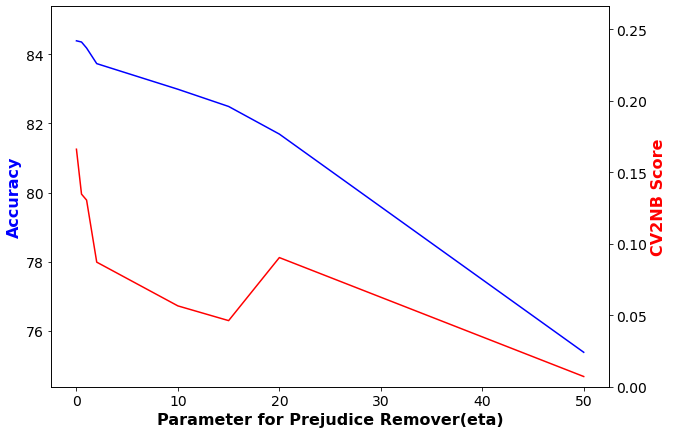

In [ ]:
fairness_plot(eta_value,'Parameter for Prejudice Remover(eta)',acc,"Accuracy",cvs_score,"CV2NB Score")